# Helmholtz 1D - AutoAMG on a Fixed Domain Size - Multilevel

## Goal
Given the Helhmholtz operator $A = \Delta + k^2 I$ on a fixed domain with periodic boundary conditions, find **test functions** $x$ of unit $l_2$ norm with small $\|A x\|$; i.e., near-null-space components, and a multilevel hierarchy that is able to solve $A u = f$ fast.

In general, $k=k(x)$ varies over the domain. In thesse experiments, $k$ is constant, but we do not assume this knowledge.

## Discretization
We use the 5-point finite difference $A^h = [-1, 16, -30 + 12 (kh)^2, 16, -1]$. In this experiment we use a fixed periodic domain with $n=96$ points and a small $kh=0.5$.

In [259]:
import logging
import numpy as np
import helmholtz as hm
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm
from scipy.sparse.linalg import eigs

import helmholtz as hm
import helmholtz.setup.hierarchy as hierarchy

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=3, suppress=True)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

logger = logging.getLogger("main")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Finest-level Eigenvalues

Smallest-magnitude eigenvalue -5.770850586968641e-10


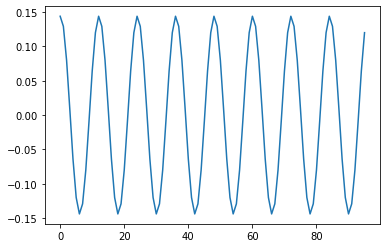

In [260]:
n = 96
#kh = 0.5
# Exactly 12 gridpoints per wavelength.
kh = 0.52338538
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()

lam, v = eig(a.todense())
lam = np.real(lam)
ind = np.argsort(np.abs(lam))
lam = lam[ind]
v = v[:, ind]
print("Smallest-magnitude eigenvalue", lam[0])
plt.plot(v[:, 0]);

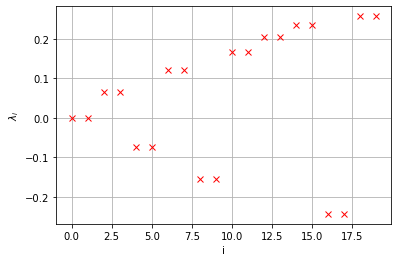

In [261]:
plt.plot(lam[:20], "rx")
plt.grid(True)
plt.xlabel("i")
plt.ylabel(r"$\lambda_i$");

## Two-level Bootstrap
We perform 4 bootstrap cycles, starting from 20 random test functions.
* R is constructed by SVD.
<!-- * P is contructed by regularized LS. -->
* P = R^T.
We measure the Residual to Error Ratio (RER) of test functions the two-level cycle convergence factor for $A x = 0$ (solving exactly at the coarse level), with $\nu_1+\nu_2=4$ relaxations per cycle 

In [262]:
# Fixed seed for reproducible results.
np.random.seed(0)

num_examples = 25
max_levels = 2
num_bootstrap_steps = 3
threshold = 0.1
interpolation_method = "svd" # "ls"
num_sweeps = 10

In [263]:
# # Initialize test functions (to random) and hierarchy at coarsest level.
# level = hierarchy.create_finest_level(a)
# multilevel = hm.hierarchy.multilevel.Multilevel(level)

# x, multilevel = hm.setup.auto_setup.setup(a, max_levels=3, num_bootstrap_steps=num_bootstrap_steps, num_examples=20,
#                               interpolation_method="svd", threshold=0.1)

## Level 0->1: Two-level Coarsening + Bootstrapping

In [264]:
_LOGGER = logger
x_log = {}

# Initialize hierarchy to 1-level and fine-level test functions to random.
finest = 0
level = hierarchy.create_finest_level(a)
multilevel = hm.hierarchy.multilevel.Multilevel(level)
# TODO(orenlivne): generalize to d-dimensions. This is specific to 1D.
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
# Improve vectors with 1-level relaxation.
x_log[1] = []
x_log[1].append(x)

_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros_like(x)
x, relax_conv_factor = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x,num_sweeps=num_sweeps)
_LOGGER.info("Relax convergence factor {:.3f}".format(relax_conv_factor))
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x_log[1].append(x)

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("-" * 80)
_LOGGER.info("bootstrap with {} levels".format(x.shape[0], num_levels))
x_log[num_levels] = [x]
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    x, multilevel = hm.setup.auto_setup.bootstap(
        x, multilevel, num_levels, 1,
        num_sweeps=num_sweeps, interpolation_method=interpolation_method, threshold=threshold)
    x_log[num_levels].append(x)
    _LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x2 = x

INFO     Relax at level 0 size 96
INFO     Relax convergence factor 0.843
INFO     RER 0.308
INFO     --------------------------------------------------------------------------------
INFO     bootstrap with 96 levels
INFO     Bootstrap step 1/3
INFO     Relax cycle conv factor 0.994 asymptotic RQ 0.228 RER 0.261 P error -1.000
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
INFO     Agg [4 4 4 8 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
INFO     nc  [2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
INFO     Energy error mean 0.0745 max 0.0980
INFO     Mock cycle conv factor [0.575 0.323 0.193 0.135 0.143]
INFO     fit  set size 20 P error mean 0.07 max 0.09
INFO     test set size 5  P error mean 0.09 max 0.10
INFO     Level 1 size 48
INFO     RER 0.165
INFO     Bootstrap step 2/3
INFO     Relax cycle conv factor 0.902 asymptotic RQ -0.009 RER 0.066 P error 0.058
INFO     Improving vectors by relaxation cycles
INFO     Coarsening level 0->1
INFO     Agg [4 4 4 

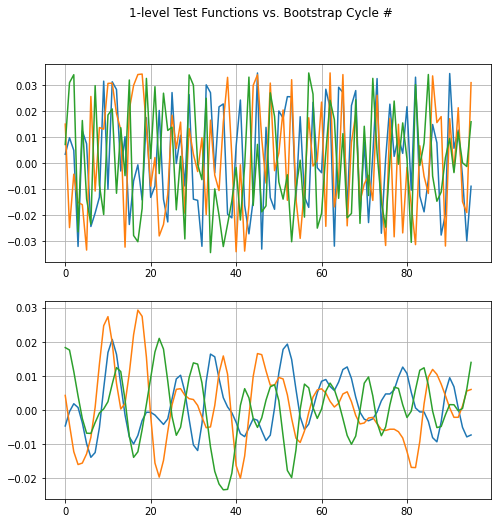

In [265]:
x_all = x_log[1]
fig, axs = plt.subplots(len(x_all), 1, figsize=(8, 8))
fig.suptitle('1-level Test Functions vs. Bootstrap Cycle #')
for i, x in enumerate(x_all):
    ax = axs[i]
    for j in range(3):
        ax.plot(x[:, j])
    ax.grid(True);

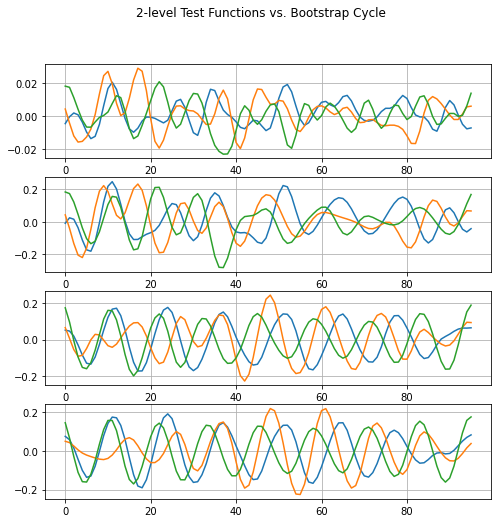

In [266]:
x_all = x_log[2]
fig, axs = plt.subplots(len(x_all), 1, figsize=(8, 8))
fig.suptitle('2-level Test Functions vs. Bootstrap Cycle')
for i, x in enumerate(x_all):
    ax = axs[i]
    for j in range(3):
        ax.plot(x[:, j])
    ax.grid(True);

In [267]:
# # Bootstrap 3 levels.
# x = x2
# num_levels = 3
# _LOGGER.info("-" * 80)
# _LOGGER.info("bootstrap with {} levels".format(x.shape[0], num_levels))
# x_log[num_levels] = [x]
# for i in range(num_bootstrap_steps):
#     _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
#     x, multilevel = hm.setup.auto_setup.bootstap(x, multilevel, num_levels, num_sweeps=num_sweeps,
#                              interpolation_method=interpolation_method, threshold=threshold)
#     x_log[num_levels].append(x)
#     _LOGGER.info("RER {:.2f}".format(norm(a.dot(x)) / norm(x)))

In [268]:
# x_all = x_log[3]
# fig, axs = plt.subplots(len(x_all), 1, figsize=(8, 8))
# fig.suptitle('2-level Test Functions vs. Bootstrap Cycle')
# for i, x in enumerate(x_all):
#     ax = axs[i]
#     for j in range(5):
#         ax.plot(x[:, j])
#     ax.grid(True);

## Level 1->2: Two-level Coarsening + Bootstrapping

In [282]:
level = multilevel.level[1]
a1 = level.a
x = level.coarsen(x2)
np.random.seed(0)

# x1_improved, multilevel1 = hm.setup.auto_setup.setup(a1, max_levels=2, 
#                                                      num_bootstrap_steps=5,
#                                                      num_sweeps=30, print_frequency=3,
#                                                      num_examples=num_examples, 
#                                                      interpolation_method=interpolation_method, 
#                                                      threshold=threshold, x=x1)

_LOGGER = logger
x_log = {}

# Initialize hierarchy to 1-level and fine-level test functions from finer level.
finest = 0
multilevel1 = hm.hierarchy.multilevel.Multilevel(level)
x_log[1] = []
x_log[1].append(x)

_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros_like(x)
print(x.shape, b.shape, level.size)
x, relax_conv_factor = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("Relax convergence factor {:.3f}".format(relax_conv_factor))
_LOGGER.info("RER {:.3f}".format(norm(a1.dot(x)) / norm(x)))
x_log[1].append(x)

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("-" * 80)
_LOGGER.info("bootstrap with {} levels".format(x.shape[0], num_levels))
x_log[num_levels] = [x]
num_bootstrap_steps = 4
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    x, multilevel1 = hm.setup.auto_setup.bootstap(
        x, multilevel1, num_levels, relax_conv_factor,
        num_sweeps=num_sweeps, interpolation_method=interpolation_method, threshold=threshold,
        print_frequency=1)
    x_log[num_levels].append(x)
    _LOGGER.info("RER {:.3f}".format(norm(a1.dot(x)) / norm(x)))

INFO     Relax at level 0 size 48
(48, 25) (48, 25) 48
INFO     Relax convergence factor 0.991
INFO     RER 0.062
INFO     --------------------------------------------------------------------------------
INFO     bootstrap with 48 levels
INFO     Bootstrap step 1/4
INFO         0 |r| 4.35531040e+00 RER 1.02813
INFO         1 |r| 1.80338600e-01 (0.04141) RER 0.18034 (0.17540) 1.00000
INFO         2 |r| 1.49395510e-01 (0.82842) RER 0.14940 (0.82842) 1.00000
INFO         3 |r| 1.35074819e-01 (0.90414) RER 0.13507 (0.90414) 1.00000
INFO         4 |r| 1.27981410e-01 (0.94749) RER 0.12798 (0.94749) 1.00000
INFO         5 |r| 1.23988850e-01 (0.96880) RER 0.12399 (0.96880) 1.00000
INFO         6 |r| 1.21366259e-01 (0.97885) RER 0.12137 (0.97885) 1.00000
INFO         7 |r| 1.19367564e-01 (0.98353) RER 0.11937 (0.98353) 1.00000
INFO         8 |r| 1.17651608e-01 (0.98562) RER 0.11765 (0.98562) 1.00000
INFO         9 |r| 1.16056566e-01 (0.98644) RER 0.11606 (0.98644) 1.00000
INFO        10 |r| 1.1

* Even though the test function RER decreases, the two-level convergence factor is excellent after one bootstrap cycle, then gets worse.
* Even though $R$ is accurate in the energy norm (i.e., the coarse values reconstruct the value of the fine variables to $10\%$ error), theer exist test functions (not used in the fit) with large interpolation error ($100\%$!).

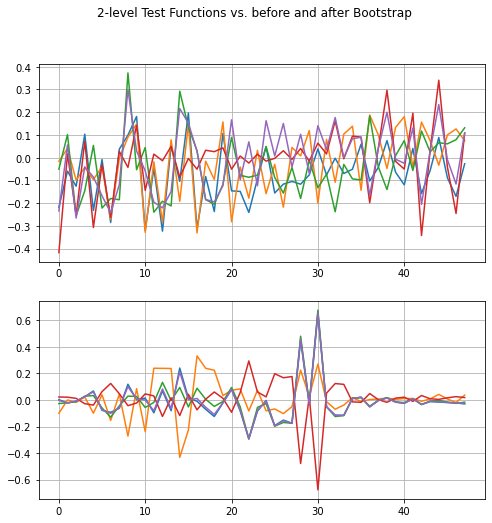

In [271]:
x_all = [x1, x1_improved]
fig, axs = plt.subplots(len(x_all), 1, figsize=(8, 8))
fig.suptitle('2-level Test Functions vs. before and after Bootstrap')
for i, x in enumerate(x_all):
    ax = axs[i]
    for j in range(5):
        ax.plot(x[:, j])
    ax.grid(True);

In [272]:
# Append level 2 found by 1->2 coarsening into the hierarchy of level 0.
#multilevel.level.append(multilevel1.level[1])
multilevel.level.append(multilevel1.level[1])

## Relaxation Cycle Convergence Factor vs. #levels

In [273]:
# 1-level: 4 relaxations = 1 iteration so we can compare with a relaxation cycle.
level = multilevel.level[0]
b = np.zeros((level.size, ))

y_all = {}
for num_levels in range(1, len(multilevel.level) + 1):
    print("#levels", num_levels)
    if num_levels == 1:
        def relax_cycle(x):
            for i in range(4):
                x = level.relax(x, b)
            return x
    else:
        def relax_cycle(x):
            return hm.solve.relax_cycle.relax_cycle(multilevel, 1.0, 2, 2, 4, num_levels=num_levels).run(x)
    y, conv_factor = hm.solve.run.run_iterative_method(
        level.operator, relax_cycle, hm.solve.run.random_test_matrix((level.size, ), num_examples=1), 
        10, print_frequency=1)
    y_all[num_levels] = y
    print("Conv Factor {:.5f}".format(conv_factor))

#levels 1
INFO         0 |r| 2.88869175e+00 RER 2.88869
INFO         1 |r| 3.81244885e-01 (0.13198) RER 0.61778 (0.21386) 0.61712
INFO         2 |r| 1.98756062e-01 (0.52133) RER 0.35650 (0.57707) 0.55752
INFO         3 |r| 1.56510457e-01 (0.78745) RER 0.30091 (0.84406) 0.52013
INFO         4 |r| 1.33568407e-01 (0.85342) RER 0.27190 (0.90360) 0.49124
INFO         5 |r| 1.17361596e-01 (0.87866) RER 0.25099 (0.92309) 0.46760
INFO         6 |r| 1.04848123e-01 (0.89338) RER 0.23423 (0.93321) 0.44764
INFO         7 |r| 9.47785102e-02 (0.90396) RER 0.22020 (0.94011) 0.43042
INFO         8 |r| 8.65643836e-02 (0.91333) RER 0.20842 (0.94652) 0.41533
INFO         9 |r| 7.97786310e-02 (0.92161) RER 0.19849 (0.95235) 0.40193
INFO        10 |r| 7.40853971e-02 (0.92864) RER 0.19001 (0.95729) 0.38990
Conv Factor 0.91210
#levels 2
INFO         0 |r| 2.73653055e+00 RER 2.73653
INFO         1 |r| 6.64368684e-01 (0.24278) RER 0.66437 (0.24278) 1.00000
INFO         2 |r| 2.48018280e-01 (0.37331) RER 0.2480

0.06573794792617964


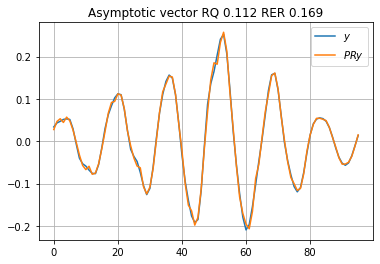

In [274]:
# Asymptotic vector of 3-level relaxation cycle is a smooth component.
coarse_level = multilevel.level[1]
p = coarse_level.p
r = coarse_level.r
y = y_all[3].flatten()
plt.title("Asymptotic vector RQ {:.3f} RER {:.3f}".format(level.rq(y), norm(level.operator(y))/norm(y)))
plt.plot(y, label="$y$")
correction = p.dot(r.dot(y))
plt.plot(correction, label="$P R y$")
plt.legend()
plt.grid(True);
print(norm(y - correction) / norm(y))

### Level 1->2 Relaxation Cycle

In [275]:
# 1-level: 4 relaxations = 1 iteration so we can compare with a relaxation cycle.
l = 1
level = multilevel.level[l]
b = np.zeros((level.size, ))
ml = hm.hierarchy.multilevel.Multilevel(level)
ml.level = multilevel.level[l:]

y_all = {}
for num_levels in range(1, len(ml.level) + 1):
    print("#levels", num_levels)
    if num_levels == 1:
        def relax_cycle(x):
            for i in range(4):
                x = level.relax(x, b)
            return x
    else:
        def relax_cycle(x):
            return hm.solve.relax_cycle.relax_cycle(ml, 1.0, 2, 2, 4, num_levels=num_levels).run(x)
    y, conv_factor = hm.solve.run.run_iterative_method(
        level.operator, relax_cycle, hm.solve.run.random_test_matrix((level.size, ), num_examples=1), 
        10,  print_frequency=1)
    y_all[num_levels] = y
    print("Conv Factor {:.5f}".format(conv_factor))

#levels 1
INFO         0 |r| 1.05845371e+00 RER 1.05845
INFO         1 |r| 1.89286486e-01 (0.17883) RER 0.31474 (0.29736) 0.60140
INFO         2 |r| 1.31631639e-01 (0.69541) RER 0.26169 (0.83145) 0.50300
INFO         3 |r| 1.02283811e-01 (0.77705) RER 0.23105 (0.88289) 0.44270
INFO         4 |r| 8.32678065e-02 (0.81409) RER 0.20745 (0.89789) 0.40138
INFO         5 |r| 7.01139745e-02 (0.84203) RER 0.18912 (0.91162) 0.37074
INFO         6 |r| 6.05185191e-02 (0.86314) RER 0.17460 (0.92321) 0.34662
INFO         7 |r| 5.31938463e-02 (0.87897) RER 0.16275 (0.93215) 0.32684
INFO         8 |r| 4.73781253e-02 (0.89067) RER 0.15273 (0.93844) 0.31020
INFO         9 |r| 4.26112073e-02 (0.89939) RER 0.14396 (0.94259) 0.29599
INFO        10 |r| 3.86112895e-02 (0.90613) RER 0.13609 (0.94531) 0.28372
Conv Factor 0.88753
#levels 2
INFO         0 |r| 1.29541030e+00 RER 1.29541
INFO         1 |r| 3.74708901e-01 (0.28926) RER 0.37471 (0.28926) 1.00000
INFO         2 |r| 3.03177134e-01 (0.80910) RER 0.3031

0.4815671262757061


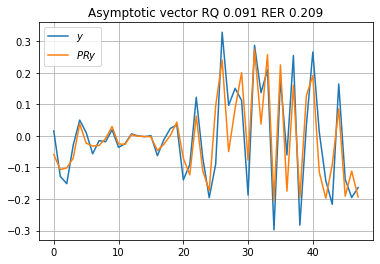

In [276]:
# Asymptotic vector of 2-level relaxation cycle at level 1 is still smooth.
coarse_level = ml.level[1]
p = coarse_level.p
r = coarse_level.r
y = y_all[2].flatten()
plt.plot(y, label="$y$")
plt.title("Asymptotic vector RQ {:.3f} RER {:.3f}".format(level.rq(y), norm(level.operator(y))/norm(y)))
correction = p.dot(r.dot(y))
plt.plot(correction, label="$P R y$")
plt.legend()
plt.grid(True);
print(norm(y - correction) / norm(y))

### Fine vs. Coarse Operator Eigenvalues

In [277]:
lam = [None] * len(multilevel)
v = [None] * len(multilevel)
for l in range(len(multilevel)):
    level = multilevel.level[l]
    lam[l], v[l] = eig(level.a.todense(), b=level.b.todense())
    lam[l] = np.real(lam[l])
    ind = np.argsort(np.abs(lam[l]))
    lam[l] = lam[l][ind]
    v[l] = v[l][:, ind]

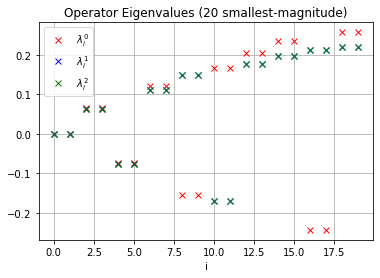

In [278]:
k = 20
lf = lam[0][:k][:, None] 
lc = lam[1][:k][:, None]
l2 = lam[2][:k][:, None]

plt.plot(lf, 'rx', label="$\lambda_i^0$")
plt.plot(lc, 'bx', label="$\lambda_i^1$")
plt.plot(lc, 'gx', label="$\lambda_i^2$")
plt.xlabel("i")
plt.grid(True)
plt.title("Operator Eigenvalues ({} smallest-magnitude)".format(k));
plt.legend();
#plt.xlim([-0.3, 0.3]);
#plt.ylim([-0.1, 0.1]);

In [279]:
pd.DataFrame(np.concatenate((lf, lc, l2,
                             np.abs(lc - lf)/np.abs(lf), np.abs(l2 - lf)/np.abs(lf),
                            ),  axis=1),
            columns=("lam0", "lam1", "lam2", "rel error 1", "rel error 2"))

,lam0,lam1,lam2,rel error 1,rel error 2
0,-5.770853e-10,-0.000048,0.000161,82806.935403,279503.966057
1,-5.770859e-10,-0.000247,-0.000169,428264.884181,293467.585479
2,6.413266e-02,0.061635,-0.051001,0.038945,1.795238
3,6.413266e-02,0.061818,-0.053243,0.036099,1.830200
4,-7.259602e-02,-0.077008,0.071808,0.060778,1.989148
5,-7.259602e-02,-0.077346,0.072338,0.065423,1.996453
6,1.197599e-01,0.110265,-0.074976,0.079287,1.626054
7,1.197599e-01,0.110782,-0.075805,0.074963,1.632977
8,-1.535953e-01,0.148070,-0.084261,1.964026,0.451410
9,-1.535953e-01,0.148556,-0.087129,1.967192,0.432734


Eigenvalue -5.770853274874014e-10 -4.778724452054114e-05 -0.05100070487824005


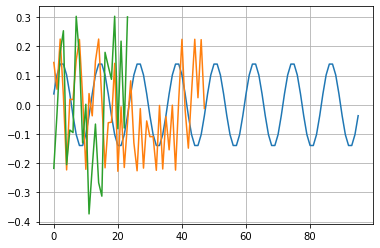

In [280]:
# Lowesst eigenfunction at levels 0..2.
plt.plot(v[0][:, 0])
plt.plot(v[1][:, 0])
plt.plot(v[2][:, 2])
plt.grid(True);
print("Eigenvalue", lam[0][0], lam[1][0], lam[2][2])

## Observations
#### 2-level
* We get a good result: mock cycle rates are good and improve with #relaxation sweeps (0.53, 0.33, 0.2, ...).
* The test function RER decreases with bootstrap cycles.
* The two-level relaxation cycle is able to reduce the residual faster than 1-level relaxation.

#### 3-level
* The mock cycle rates are much larger, but still improve with the number of relaxation sweeps, indicating that Kaczmarz is a less effective smoother for the level 1 equations than level 0 (~0.85, 0.81, 0.79, ...) and that we need more relaxations at level 1 during a cycle.
* The test function RER oscillates with bootstrap cycles.
* The 3-level relaxation cycle RER does not converge to the smallest eigenvalue. This indicates that there is a error component that is not reduced at all.

#### Questions
* We have a good quality metric of test functions (RER). We have a good metric of a coarsening operator (mock cycle). What is a good qualiy metric of a coarse level? Is it the convergence rate of a 2-level relaxation cycle? (converrgence needs to be measured towards the lowest eigenpair?).
* How can we find which points are not coarsened well? Can we tell by the asymptotically slowest vector of the relaxation cycle?

In [146]:
from scipy.linalg import svd

In [149]:
X = np.random.random((10, 5))
W = np.diag(np.random.random(10,))

In [151]:
svd(X)

(array([[-0.405,  0.19 , -0.261, -0.025,  0.404, -0.223,  0.122, -0.014, -0.608, -0.366],
        [-0.21 ,  0.376, -0.606,  0.089, -0.09 ,  0.299, -0.178,  0.388,  0.063,  0.394],
        [-0.371, -0.191, -0.222,  0.272, -0.189, -0.683,  0.214, -0.002,  0.382,  0.094],
        [-0.345,  0.049, -0.095, -0.343,  0.189,  0.048, -0.564, -0.435,  0.416, -0.185],
        [-0.281, -0.217,  0.087, -0.79 , -0.027,  0.008,  0.328,  0.22 , -0.022,  0.293],
        [-0.336, -0.613, -0.164,  0.28 ,  0.019,  0.573,  0.212, -0.112,  0.021, -0.138],
        [-0.172,  0.494,  0.032, -0.075, -0.56 ,  0.204,  0.416, -0.319,  0.076, -0.289],
        [-0.317, -0.052,  0.357,  0.046, -0.333,  0.   , -0.355,  0.602, -0.02 , -0.409],
        [-0.162,  0.321,  0.35 ,  0.17 ,  0.572,  0.147,  0.332,  0.232,  0.454, -0.025],
        [-0.433,  0.103,  0.47 ,  0.247, -0.067,  0.024, -0.168, -0.284, -0.308,  0.559]]),
 array([3.76 , 1.054, 0.737, 0.617, 0.354]),
 array([[-0.41 , -0.426, -0.372, -0.511, -0.501],
   

In [152]:
svd(W.dot(X))

(array([[-0.099,  0.065, -0.108,  0.008,  0.128, -0.528, -0.069, -0.187, -0.584, -0.547],
        [-0.188,  0.254, -0.776, -0.218,  0.014,  0.245, -0.121,  0.269, -0.262,  0.184],
        [-0.348, -0.066, -0.209, -0.181, -0.16 , -0.706,  0.066,  0.076,  0.473,  0.2  ],
        [-0.314,  0.145, -0.229,  0.417,  0.283,  0.181, -0.339, -0.391,  0.442, -0.278],
        [-0.21 , -0.028, -0.008,  0.781,  0.108, -0.131,  0.274,  0.257, -0.246,  0.339],
        [-0.587, -0.663,  0.053, -0.22 ,  0.183,  0.265,  0.198, -0.012, -0.112, -0.1  ],
        [-0.089,  0.259, -0.159,  0.045, -0.414,  0.171,  0.738, -0.238,  0.092, -0.294],
        [-0.263,  0.098,  0.214,  0.114, -0.415,  0.096, -0.266,  0.635,  0.086, -0.446],
        [-0.214,  0.529,  0.311, -0.253,  0.609, -0.005,  0.269,  0.247,  0.092, -0.032],
        [-0.473,  0.33 ,  0.346, -0.091, -0.344,  0.059, -0.241, -0.383, -0.274,  0.372]]),
 array([2.024, 0.681, 0.382, 0.287, 0.167]),
 array([[-0.351, -0.525, -0.317, -0.473, -0.526],
   